Unusual meaning map: Treating question pairs as image / surface
---------------------------------------------------------------

Other people have already written really nice exploratory kernels which helped me to write the minimal code myself. 

In this kernel, I have tried to extract a different type of feature from which we can learn using any algorithm which can learn via image. The basic assumption behind this exercise is to capture non-sequential closeness between words.

For example:
A Question pair has pointing arrows from each of the words of one sentence to each of the words from another sentence
![A Question pair has pointing arrows from each of the words of one sentence to each of the words from another sentence][1]

  [1]: http://image.prntscr.com/image/97e92b0357a843078b61eef5ad8a183b.png

To capture this we can create NxM matrix with Word2Vec distance between each word with other. and resize the matrix just like an image to a 10x10 matrix and use this as a feature to xgboost.

In [1]:
import csv
import pip
from gensim import corpora, models, similarities
import pandas as pd
import numpy as np
train_file = "/Users/mingliangang/Desktop/Quora_Data/train.csv"
df = pd.read_csv(train_file, index_col="id")
df

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0


In [2]:
import matplotlib.pylab as plt

**Extracting unique questions**

In [3]:
questions = dict()

for row in df.iterrows():
    questions[row[1]['qid1']] = row[1]['question1']
    questions[row[1]['qid2']] = row[1]['question2']

**Creating a simple tokenizer**

In [4]:
import re
import nltk
def basic_cleaning(string):
    string = str(string)
    try:
        string = string.decode('unicode-escape')
    except Exception:
        pass
    string = string.lower()
    string = re.sub(' +', ' ', string)
    return string
sentences = []
for i in questions:
    sentences.append(nltk.word_tokenize(basic_cleaning(questions[i])))

**Creating a simple Word2Vec model from the question pair, we can use a pre-trained model instead to get better results**

In [5]:
import gensim
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

**A very simple term frequency and document frequency extractor** 

In [6]:
tf = dict()
docf = dict()
total_docs = 0
for qid in questions:
    total_docs += 1
    toks = nltk.word_tokenize(basic_cleaning(questions[qid]))
    uniq_toks = set(toks)
    for i in toks:
        if i not in tf:
            tf[i] = 1
        else:
            tf[i] += 1
    for i in uniq_toks:
        if i not in docf:
            docf[i] = 1
        else:
            docf[i] += 1

Mimic the IDF function but penalize the words which have fairly high score otherwise, and give a strong boost to the words which appear sporadically.

In [7]:
from __future__ import division
import math
def idf(word):
    return 1 - math.sqrt(docf[word]/total_docs)

In [8]:
print(idf("kenya"))

0.9907527026616816


A simple cleaning module for feature extraction

In [9]:
import re
import nltk
def basic_cleaning(string):
    string = str(string)
    string = string.lower()
    string = re.sub('[0-9\(\)\!\^\%\$\'\"\.;,-\?\{\}\[\]\\/]', ' ', string)
    string = ' '.join([i for i in string.split() if i not in ["a", "and", "of", "the", "to", "on", "in", "at", "is"]])
    string = re.sub(' +', ' ', string)
    return string

In [10]:
def w2v_sim(w1, w2):
    try:
        return model.similarity(w1, w2)*idf(w1)*idf(w2)
    except Exception:
        return 0.0

**Visualizing features**

This function will create a 10x10 matrix using MxN word pairs among the words of question pair

Q1: What do cottonmouth snakes look like?
Q2: Are there cottonmouth snakes in California?
Duplicate: 0


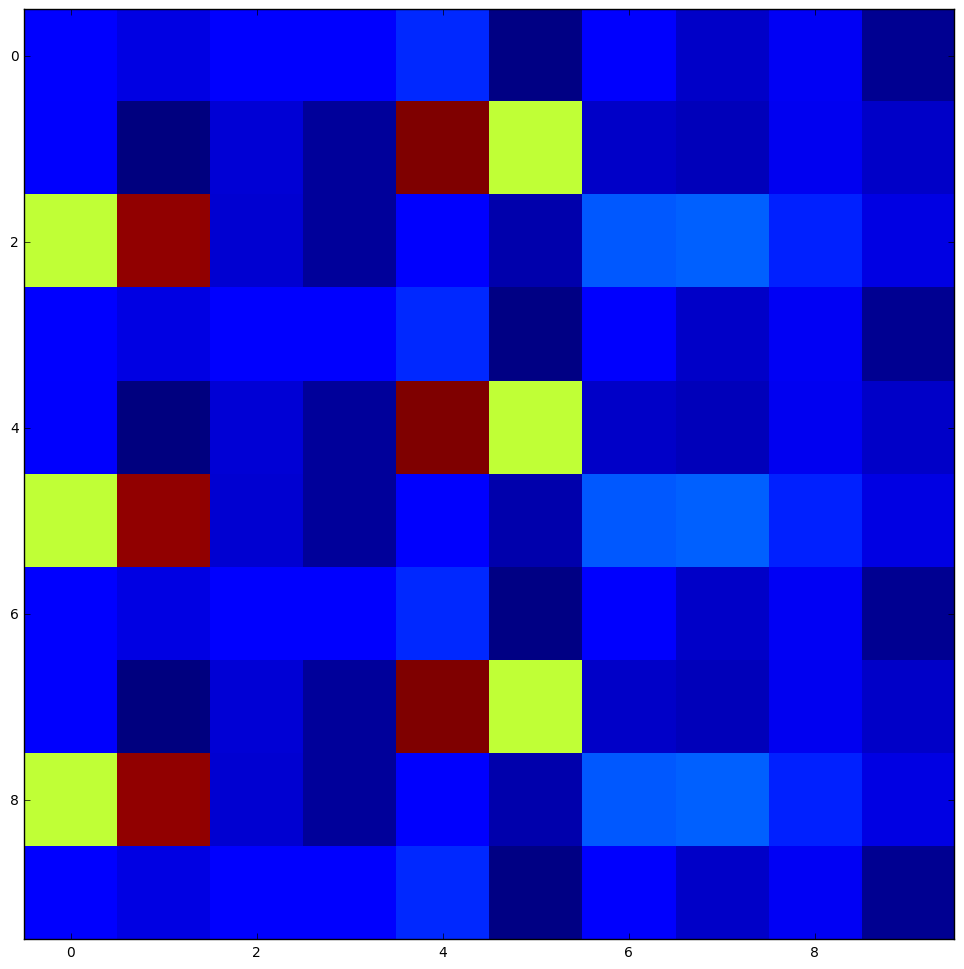

Q1: What are the strongest majors in terms of job prospects and what are the weakest majors at Western Carolina University?
Q2: What are the strongest majors in terms of job prospects and what are the weakest majors at Western Washington University?
Duplicate: 0


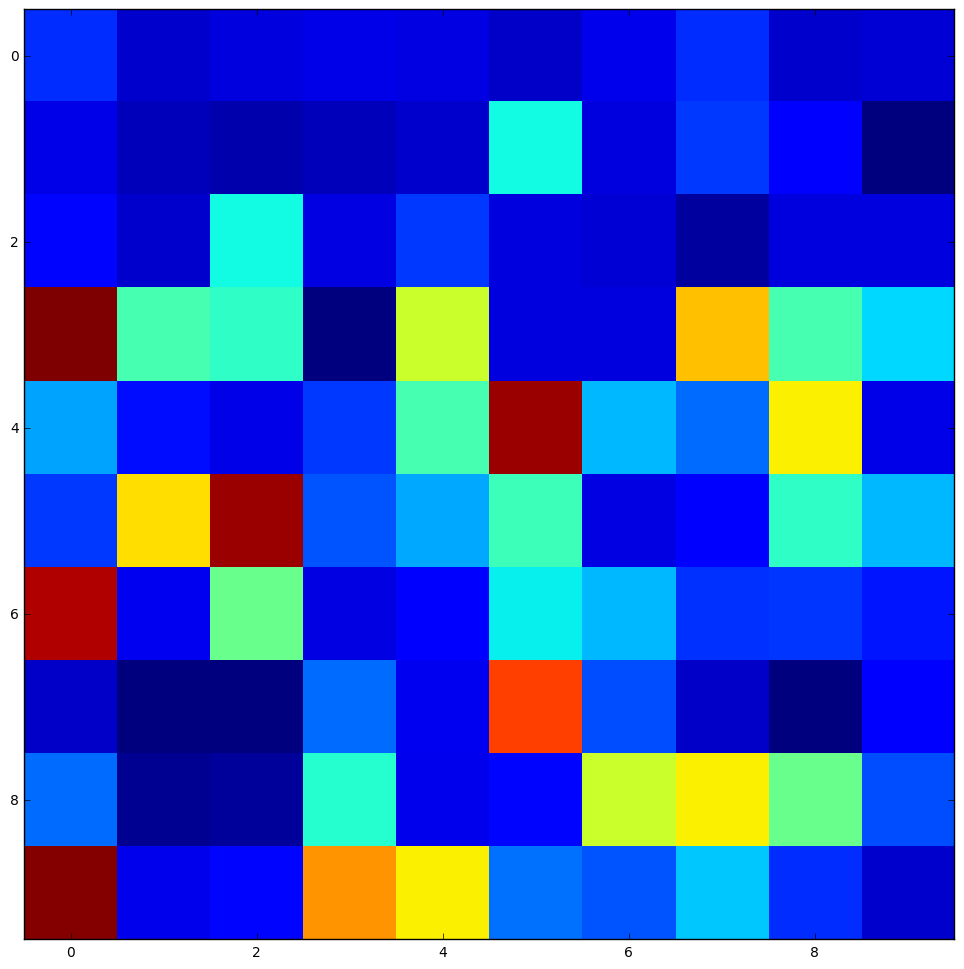

Q1: What are the major traits of a very strong mind?
Q2: What does it mean when someone says that, "You're very judgemental."? If it is a wrong trait, then how do I resolve it?
Duplicate: 0


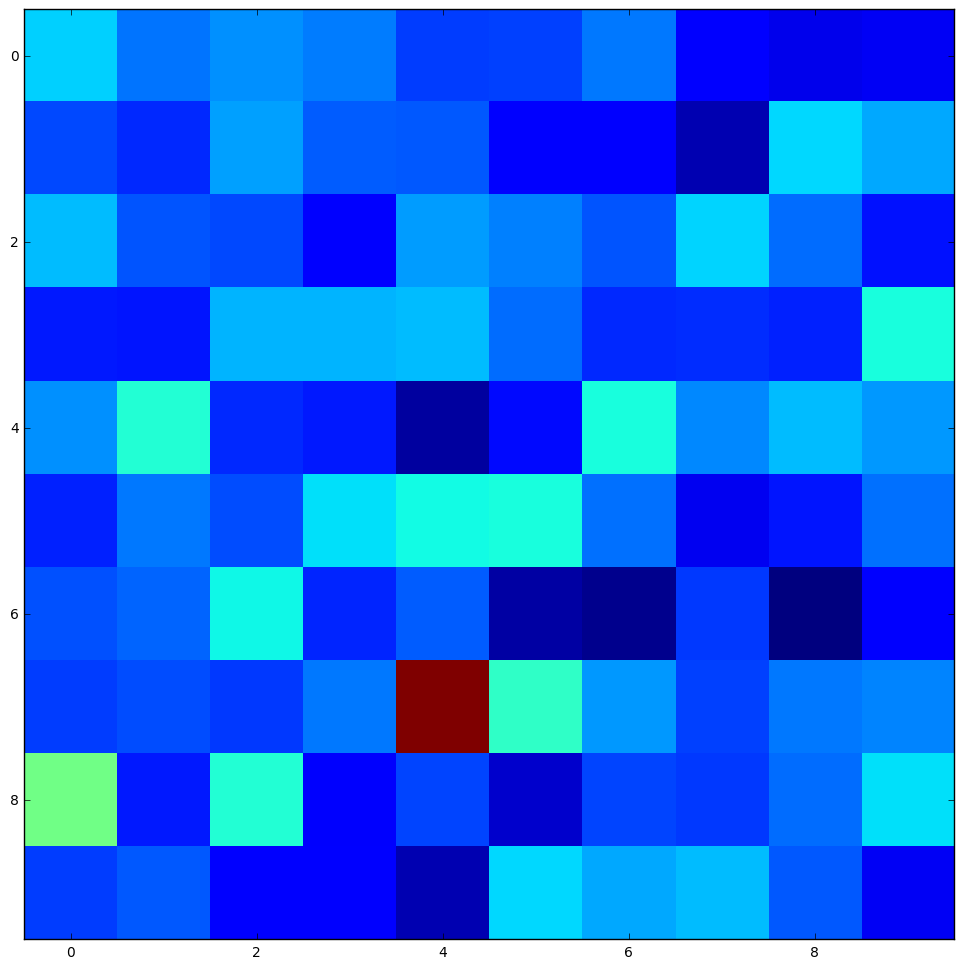

In [42]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.cm as cm
from scipy import *
df = df.sample(n=30000)
array = []
def imagify(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    print("Q1: "+ s1)
    print("Q2: "+ s2)
    print("Duplicate: " + str(row['is_duplicate']))
    
    img = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(img, order='C')
    img = np.resize(a,(10,10))
    array.append(img)
    # print img
    fig = plt.figure()
    # tell imshow about color map so that only set colors are used
    image = plt.imshow(img,interpolation='nearest')
    plt.show()
s = df.sample(n=3)
plt.close()
s.apply(imagify, axis=1, raw=True)
array = np.array(array)
np.save('maps.npy',array)

(3, 10, 10)


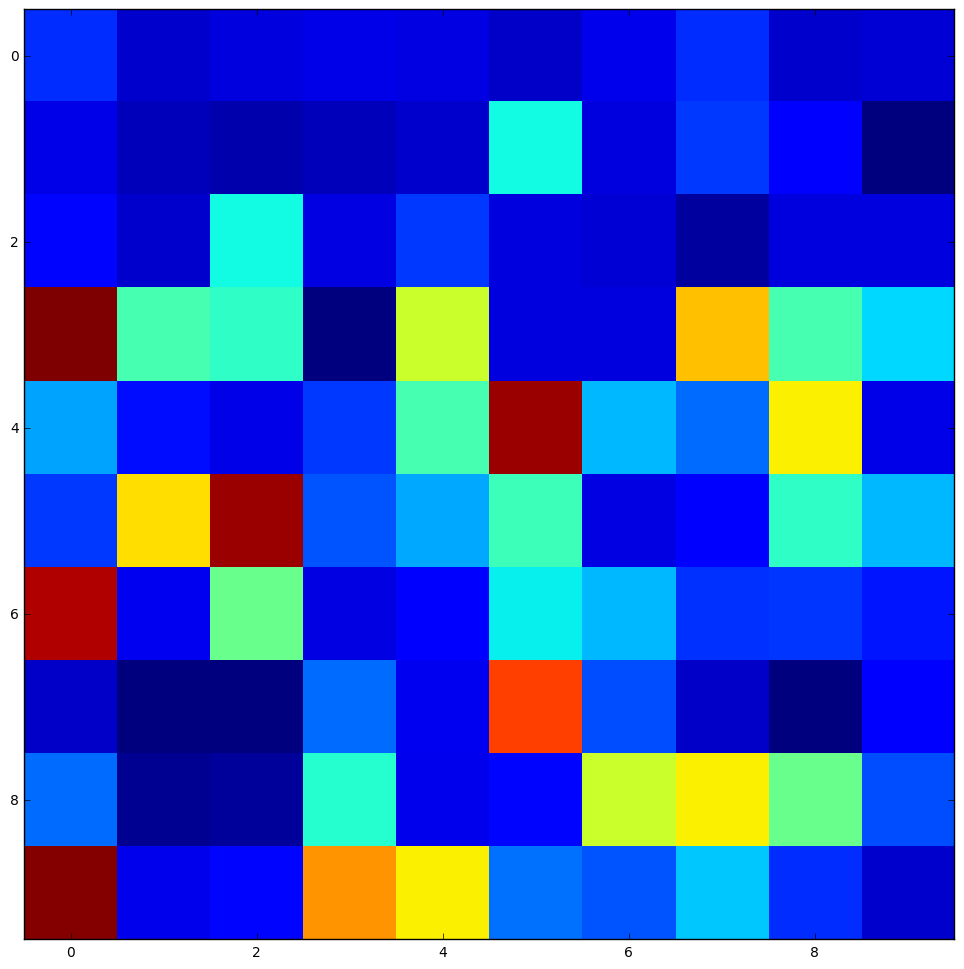

In [43]:
maps = np.load('maps.npy')
print(maps.shape)
img = maps[1]
plt.imshow(img,interpolation='nearest')
plt.show()

In [41]:
def img_feature(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    Z = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(Z, order='C')
    return [np.resize(a,(10,10)).flatten()]
s = df

img = s.apply(img_feature, axis=1, raw=True)
pix_col = [[] for y in range(100)] 
for k in img.iteritems():
        for f in range(len(list(k[1][0]))):
           pix_col[f].append(k[1][0][f])

KeyboardInterrupt: 

**Extracting Features**

In [13]:
from nltk.corpus import stopwords
from __future__ import division
stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = df.apply(word_match_share, axis=1, raw=True)

In [14]:
from __future__ import division
x_train = pd.DataFrame()

for g in range(len(pix_col)):
    x_train['img'+str(g)] = pix_col[g]

    
x_train['word_match'] = train_word_match

y_train = s['is_duplicate'].values
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]
# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.1912694846714824


In [15]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 7

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.68421	valid-logloss:0.684537
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.611014	valid-logloss:0.614419
[20]	train-logloss:0.558654	valid-logloss:0.565215
[30]	train-logloss:0.519724	valid-logloss:0.529746
[40]	train-logloss:0.490298	valid-logloss:0.503879
[50]	train-logloss:0.467402	valid-logloss:0.484391
[60]	train-logloss:0.449148	valid-logloss:0.469634
[70]	train-logloss:0.434296	valid-logloss:0.458451
[80]	train-logloss:0.421715	valid-logloss:0.449401
[90]	train-logloss:0.411058	valid-logloss:0.442463
[100]	train-logloss:0.401729	valid-logloss:0.436629
[110]	train-logloss:0.393678	valid-logloss:0.431906
[120]	train-logloss:0.386134	valid-logloss:0.427801
[130]	train-logloss:0.379287	valid-logloss:0.424316
[140]	train-logloss:0.372966	valid-logloss:0.421211
[150]	train-logloss:0.366959	valid-logloss:0.418357
[160]	train-logloss:0.361494

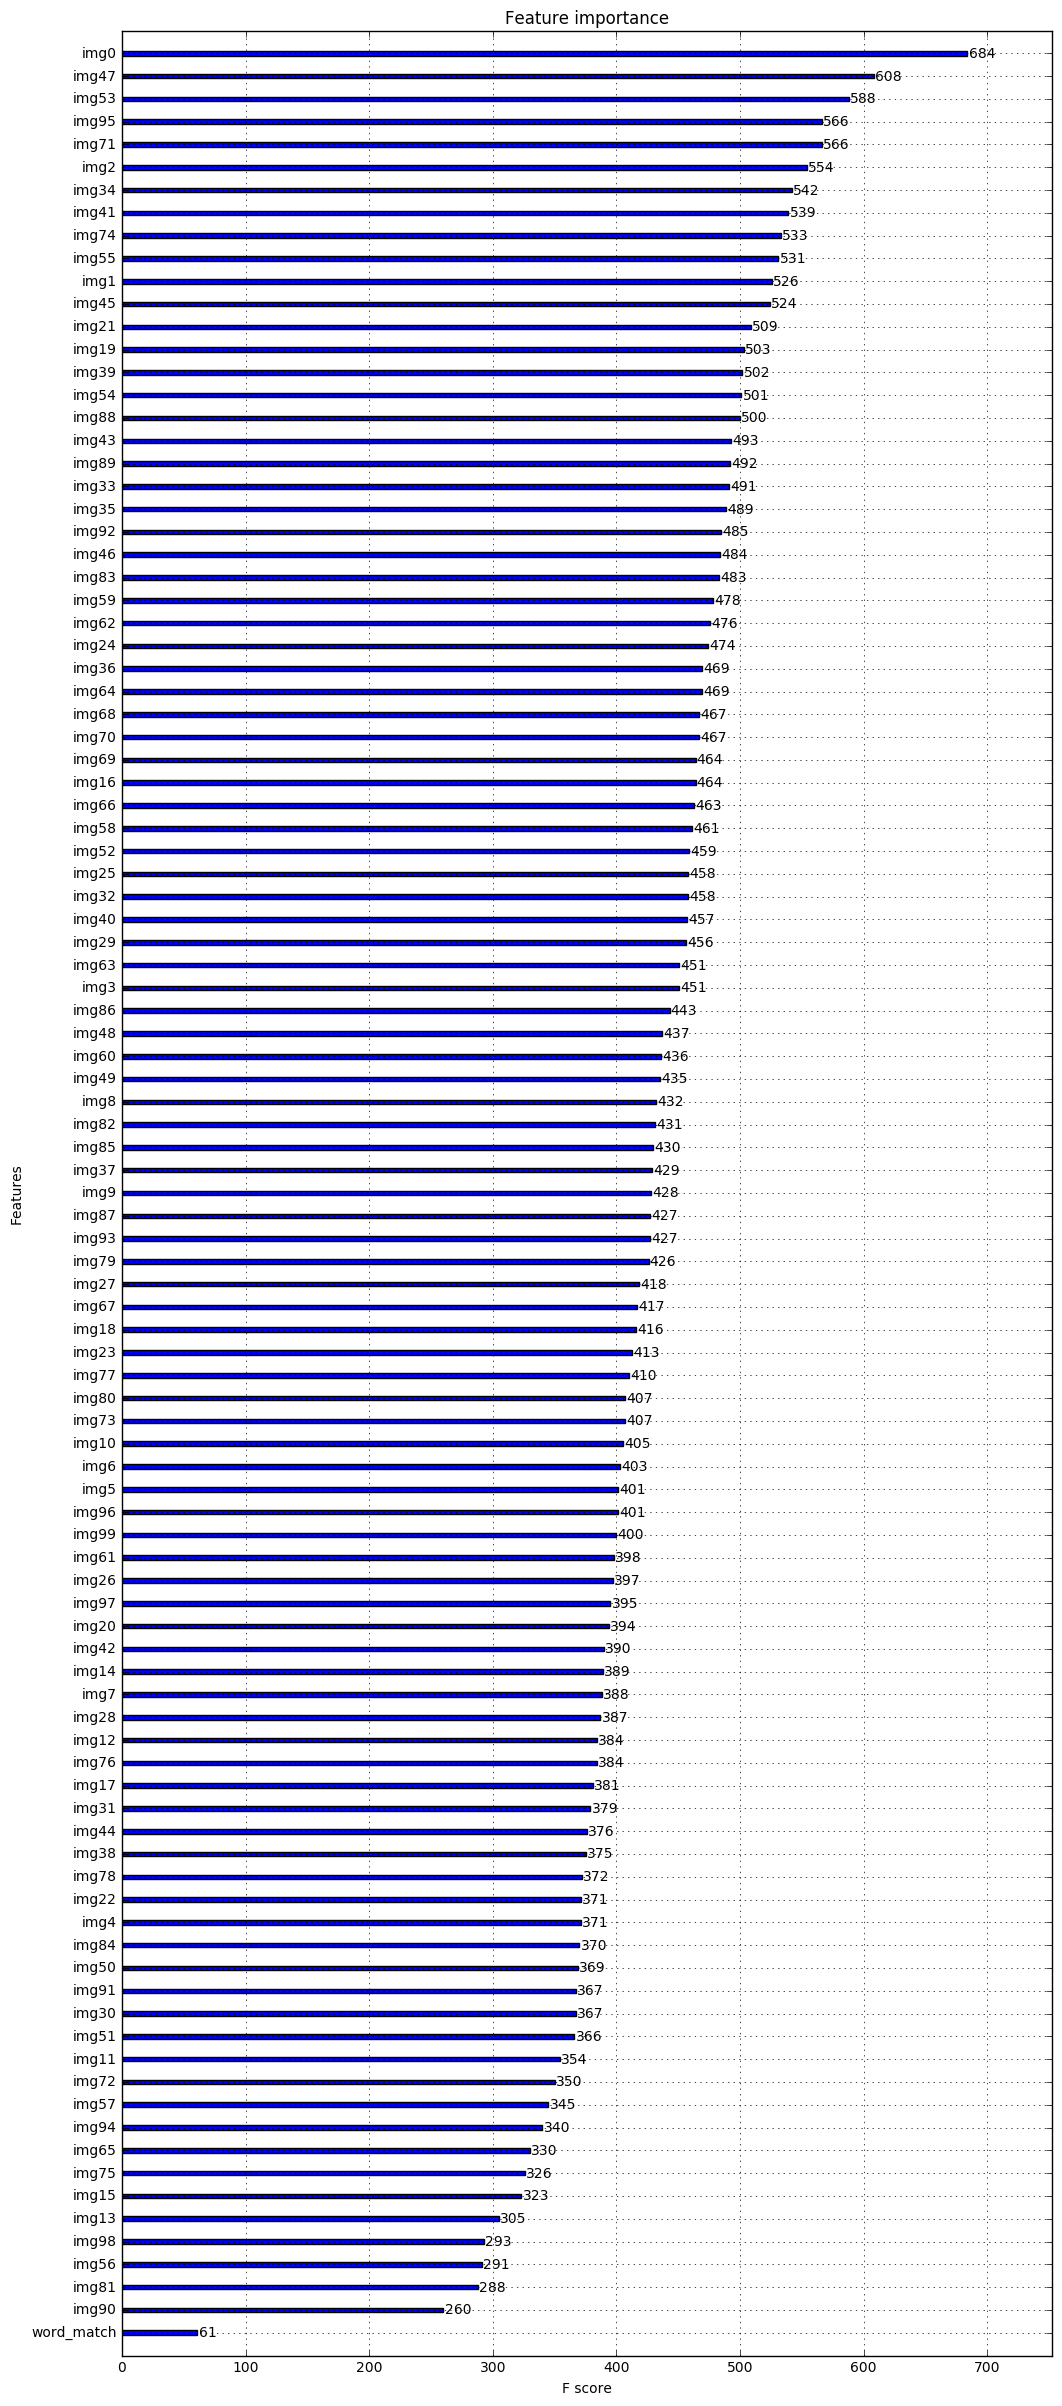

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 30.0)
xgb.plot_importance(bst); plt.show()

Using this technique and combining it with word match features I got log loss of **0.31858** on test dataset. 

I thought this feature can be of some help to others hence shared. Enjoy :)

# Stranger things part 1

<h2>Extracting the meaning map</h2>

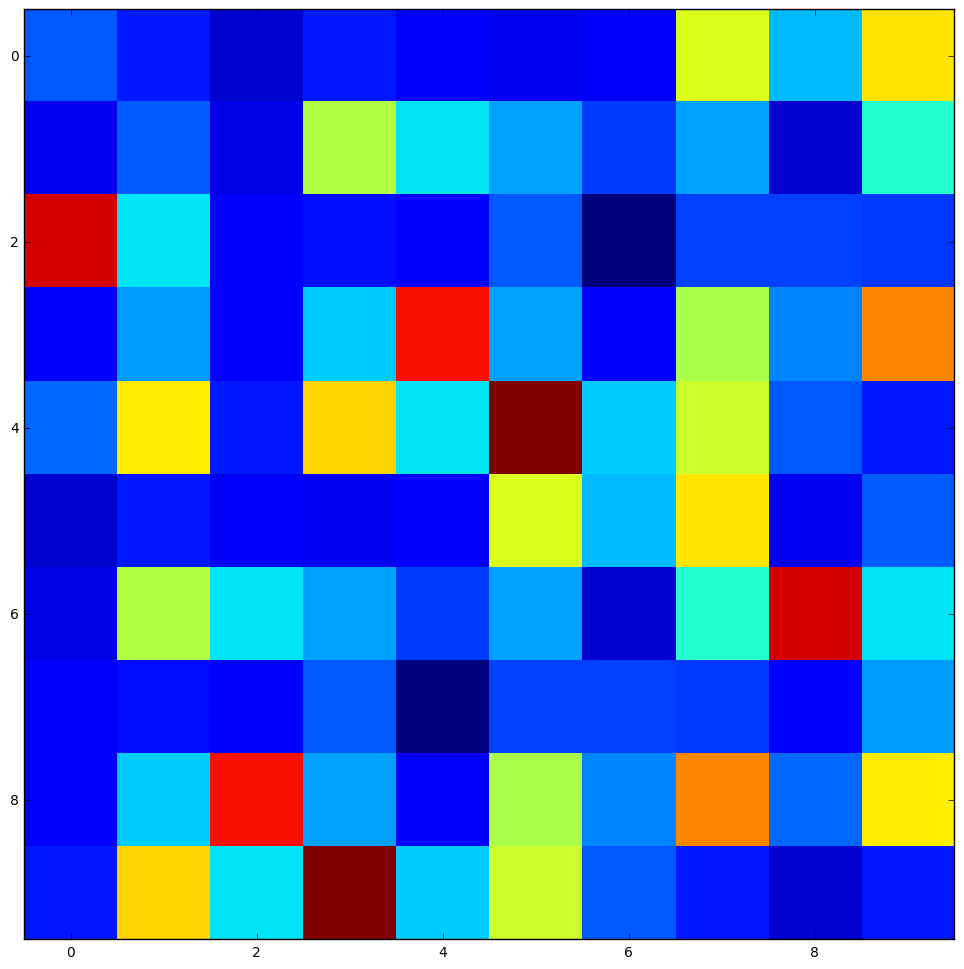

In [61]:
df = df.sample(n=30000)
array_ = []
duplicates = []
def imagify(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    img = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(img, order='C')
    img = np.resize(a,(10,10))
    
    #Stored into an array
    array_.append([img,img,img])
    duplicates.append(row['is_duplicate'])
    image = plt.imshow(img,interpolation='nearest')
    
s = df.sample(n=100)
plt.close()
s.apply(imagify, axis=1, raw=True)
array_ = np.array(array_)
dup = np.array(duplicates)
np.save('dup.npy',dup)
np.save('maps.npy',array_)

<h2>Input Images and Labels</h2>

In [62]:
map_ = np.load('maps.npy')
print(map_.shape)

(100, 3, 10, 10)


In [63]:
dup = np.load('dup.npy')
print(dup.shape)

(100,)


# Resnet-50

In [69]:
import mxnet as mx
def get_extractor():
    model = mx.model.FeedForward.load('/Users/mingliangang/altimit/data/one/stage1/resnet-50', 0, ctx=mx.cpu(), numpy_batch_size=1)
    fea_symbol = model.symbol.get_internals()["flatten0_output"]
    feature_extractor = mx.model.FeedForward(ctx=mx.cpu(), symbol=fea_symbol, numpy_batch_size=64,
                                             arg_params=model.arg_params, aux_params=model.aux_params,
                                             allow_extra_params=True)

    return feature_extractor

net = get_extractor()
def calc_features():
    batch = np.load('maps.npy')
    feats = net.predict(batch)
    print(feats.shape)
    return feats

calc_features()

[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
(100, 2048)


array([[ 1.31735563,  0.4735806 ,  0.97865778, ...,  0.15591562,
         1.4586103 ,  0.67439544],
       [ 1.37901449,  0.55828261,  1.05201364, ...,  0.18474984,
         1.47534132,  0.74506932],
       [ 1.36036468,  0.5302881 ,  1.01883733, ...,  0.1895082 ,
         1.48850107,  0.77062297],
       ..., 
       [ 1.37804067,  0.53394866,  1.00889969, ...,  0.17250001,
         1.451208  ,  0.68639791],
       [ 1.33823371,  0.52217579,  1.04111671, ...,  0.19957376,
         1.50016236,  0.78939819],
       [ 1.37137604,  0.53436661,  1.01188827, ...,  0.16106391,
         1.46454418,  0.70987028]], dtype=float32)

# PCA

In [71]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(calc_features())
scree = pca.explained_variance_ratio_
print(len(scree)) 

(100, 2048)
(100, 2048)
100


In [74]:
a = 0
for i,x in enumerate(scree):
    a += x
    if a >0.999:
        print(i)
        break

44


 So we only choose the 44 components of our PCA 

In [76]:
pca = PCA(n_components = 44)
pca.fit(calc_features())
features = pca.fit_transform(calc_features())
scree = pca.explained_variance_ratio_
print(len(scree)) 

(100, 2048)
(100, 2048)
44


In [77]:
print(features.shape)

(100, 44)


# XGBoost

In [80]:
import os
import pickle
import numpy as np
import dicom
import glob
from matplotlib import pyplot as plt
import cv2
import mxnet as mx
import pandas as pd
from sklearn import cross_validation
import xgboost as xgb

def train_xgboost(x,y):
    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
    
                                                                test_size=0.20)
    clf = xgb.XGBRegressor(max_depth=10,
                           n_estimators=1500,
                           min_child_weight=9,
                           learning_rate=0.005,
                           nthread=8,
                           subsample=0.80,
                           colsample_bytree=0.80,
                           seed=4242)

    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=True, eval_metric='logloss', early_stopping_rounds=50)
    pickle.dump(clf, open("xgboostmodel.pkl", "wb"))
    return clf

if __name__ == '__main__':
  train_xgboost(features,dup)

[0]	validation_0-logloss:0.692227
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.690643
[2]	validation_0-logloss:0.690958
[3]	validation_0-logloss:0.690894
[4]	validation_0-logloss:0.689801
[5]	validation_0-logloss:0.689677
[6]	validation_0-logloss:0.689498
[7]	validation_0-logloss:0.689296
[8]	validation_0-logloss:0.689446
[9]	validation_0-logloss:0.689362
[10]	validation_0-logloss:0.689191
[11]	validation_0-logloss:0.688404
[12]	validation_0-logloss:0.687229
[13]	validation_0-logloss:0.686873
[14]	validation_0-logloss:0.685564
[15]	validation_0-logloss:0.68513
[16]	validation_0-logloss:0.684126
[17]	validation_0-logloss:0.683888
[18]	validation_0-logloss:0.682401
[19]	validation_0-logloss:0.681412
[20]	validation_0-logloss:0.680598
[21]	validation_0-logloss:0.679372
[22]	validation_0-logloss:0.680084
[23]	validation_0-logloss:0.680245
[24]	validation_0-logloss:0.679155
[25]	validation_0-logloss:0.678797
[26]	validation_0-logloss:0.67785